In [42]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import time
import pickle
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from module.lino_module.preprocess import mode_of_freq, tde_dataset_wm
from module.lino_module.model import TransformerModel, WithAuxiliary, LossWithAuxiliary
from module.lino_module.training import training_with_auxiliary
from module.lino_module.ploter import confirmation, to_time_series, confirmation_plot

from typing import Tuple
from torch import Tensor
from torch.utils.data import DataLoader

In [37]:
parent_path = '../'
data = pd.read_csv(parent_path + '/data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 7
d_model = 24
dilation = 2
src_tgt_seq = (int(seq * 0.7),int(seq * 0.7))
step_num = seq - int(seq * 0.7)
scaler = StandardScaler

kwrgs = {'data': data,
         'seq': seq,
         'd_model': d_model,
         'dilation': dilation,
         'src_tgt_seq': src_tgt_seq,
         'step_num': step_num,
         'daily': False,
         'weekly': True,
         'weekly_num': False,
         'monthly': True,
         'scaler': scaler,
         'batch_size': 64,
         'train_rate': 0.9}

train, test = tde_dataset_wm(**kwrgs)

In [24]:
from torch.optim import Adam
# device = select_device() # mps では Transformer の attention でエラー
device = torch.device('cpu')

cat_dim = kwrgs['daily'] + kwrgs['weekly'] + kwrgs['weekly_num'] + kwrgs['monthly']
dim = d_model * (cat_dim + 1)

# モデルと損失関数
base_model = TransformerModel(d_model=dim, nhead=8, device=device)
auxiliary_model = TransformerModel(d_model=dim, nhead=8, device=device)
transformer = WithAuxiliary(base_model, auxiliary_model).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
base_func, auxiliary_func = nn.MSELoss(), nn.MSELoss()
criterion = LossWithAuxiliary(base_func, auxiliary_func).to(device)

# 学習率その他は論文の値を参考
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

In [25]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'train': train,
                  'test': test,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 80}
loss_pack = training_with_auxiliary(**training_kwrgs)
train_loss, val_loss, test_loss =loss_pack['train'], loss_pack['eval'], loss_pack['test']

------------------------------------ start -------------------------------------
                                    epoch_0                                     
train_loss:  1.8536 | validation_loss:  1.9189 | test_loss:  1.7343 | auxiliary_rate:  0.4039
                                    epoch_10                                    
train_loss:  0.6368 | validation_loss:  0.6136 | test_loss:  0.3366 | auxiliary_rate:  0.7563
                                    epoch_20                                    
train_loss:  0.5311 | validation_loss:  0.5005 | test_loss:  0.2768 | auxiliary_rate:  0.491
                                    epoch_30                                    
train_loss:  0.4602 | validation_loss:  0.4372 | test_loss:  0.2536 | auxiliary_rate:  0.859
                                    epoch_40                                    
train_loss:  0.4114 | validation_loss:  0.3943 | test_loss:  0.262 | auxiliary_rate:  0.6786
                                    epoch_50   

In [38]:
# ファイル名の作成
name = ''
for key, value in kwrgs.items():
    if key=='data':
        pass
    elif key=='scaler':
        name += f'{key}({value.__name__})_'
    else:
        name += f'{key}({value})_'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


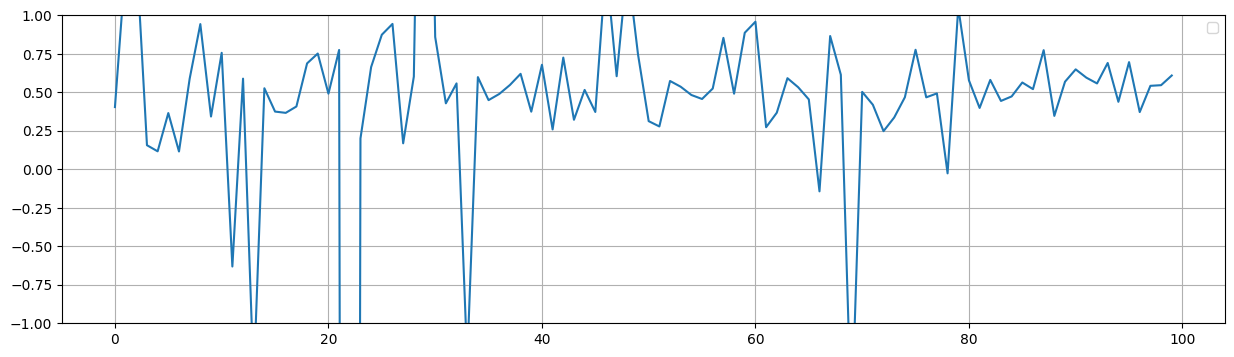

In [26]:
auxiliary_rate = [np.array(loss).mean() for loss in train_loss['auxiliary_rate']]
plt.figure(figsize=(15,4))
plt.plot(auxiliary_rate)
plt.ylim(-1, 1)
plt.grid(axis='x')
plt.grid(axis='y')
plt.legend()
plt.show()

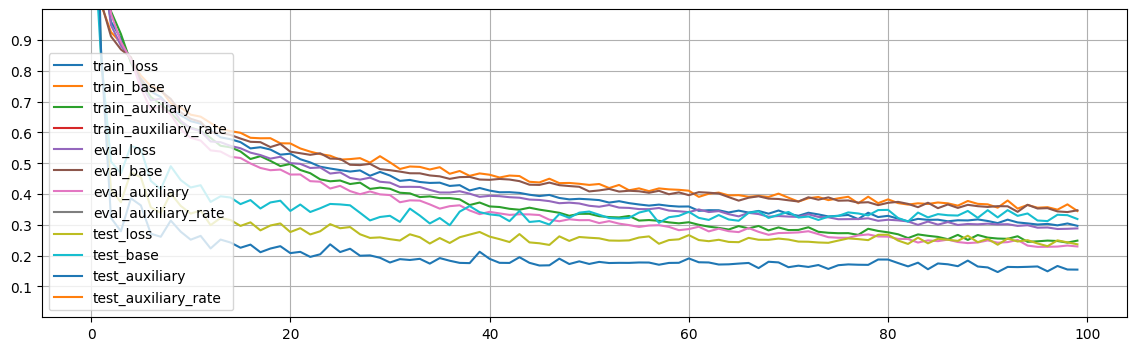

In [43]:
plt.figure(figsize=(14,4))


for mode, values in loss_pack.items():
    for key, value in values.items():
        if key == 'auxiliary_rate':
            pass
        plt.plot([np.array(loss).mean() for loss in value if key != 'auxiliary_rate'], label= f'{mode}_{key}')

plt.yticks([round(i*1e-1, 2) for i in range(1, 10)])
plt.ylim(0, 2)
plt.grid(axis='x')
plt.grid(axis='y')
plt.ylim(0, 1)
plt.legend()
plt.show()

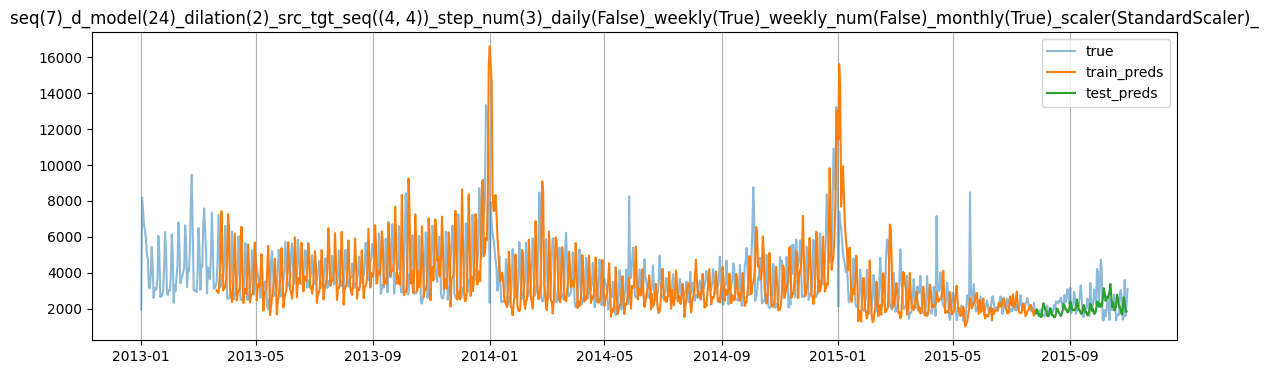

In [40]:
img_path = './img_ax/'
figsize = (14, 4)
saving = True
train_preds, test_preds = confirmation(transformer, train, test, device)
train_time_series, test_time_series, original = to_time_series(data, train_preds, test_preds, scaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

## モデルの保存

In [33]:
kwrgs['model'] = transformer
model_dir = './models_ax/'
model_name = f'epochs({epochs})' + name + '.pkl'
with open(model_dir + model_name, 'wb') as f:
    pickle.dump(kwrgs, f)

## 以下は訓練に使用したモデルと関数

モデルクラス

In [ ]:
class WithAuxiliary(nn.Module):
    def __init__(self, base_model, auxiliary_model):
        super(WithAuxiliary, self).__init__()
        self.base = base_model
        self.auxiliary = auxiliary_model

    def forward(self, src, tgt, y=None):
        base_pred = self.base(src, tgt)
        auxiliary_pred = self.base(src, tgt)
        if self.training:
            auxiliary_label = y - base_pred.squeeze(2)
            return base_pred, auxiliary_pred, auxiliary_label
        else:
            return base_pred, auxiliary_pred


class LossWithAuxiliary(nn.Module):
    def __init__(self, base_func, auxiliary_func):
        super(LossWithAuxiliary, self).__init__()
        self.base_func = base_func
        self.auxiliary_func = auxiliary_func

    def forward(self, base_pred, auxiliary_pred, y, auxiliary_label):
        base_loss = self.base_func(base_pred, y)
        auxiliary_loss = self.auxiliary_func(auxiliary_pred, auxiliary_label)
        loss = base_loss * 0.5 + auxiliary_loss * 0.5
        return loss, base_loss, auxiliary_loss

トレーニング関数

In [9]:
def training_with_auxiliary(model: object,
                            train: DataLoader,
                            test: DataLoader,
                            device: torch.device,
                            criterion: object,
                            optimizer: object,
                            epochs: int,
                            verbose=10,
                            center=80) -> Tuple[object, Tensor, Tensor]:
    """訓練用関数"""
    loss_pack = {'train': {'loss': [], 'base': [],
                           'auxiliary': [], 'auxiliary_rate': []},
                 'eval': {'loss': [], 'base': [],
                          'auxiliary': [], 'auxiliary_rate': []},
                 'test': {'loss': [], 'base': [],
                          'auxiliary': [], 'auxiliary_rate': []}}
    print(' start '.center(center, '-'))
    start_point = time.time()
    for epoch in range(epochs):
        epoch_loss = {'train': {'loss': [], 'base': [],
                                'auxiliary': [], 'auxiliary_rate': []},
                      'eval': {'loss': [], 'base': [],
                               'auxiliary': [], 'auxiliary_rate': []},
                      'test': {'loss': [], 'base': [],
                               'auxiliary': [], 'auxiliary_rate': []}}

        cache = None
        for i, pack in enumerate(train):
            inputs = [content.to(device) for content in pack]
            # モデル訓練
            if i == 0:
                pass
            else:
                # キャッシュから１バッチ前のデータで訓練
                loss = training_eval(model, optimizer, criterion, cache,
                                        epoch_loss, 'train')
                # 勾配計算
                loss.backward()
                optimizer.step()

            # モデル評価
            training_eval(model, optimizer, criterion, inputs,
                          epoch_loss, 'eval')
            # データをキャッシュに保存して次回の訓練データにする
            cache = inputs

        # テストデータによる評価
        for pack in test:
            inputs = [content.to(device) for content in pack]
            training_eval(model, optimizer, criterion, inputs,
                          epoch_loss, 'test')

        # 損失データの登録
        appender(loss_pack, epoch_loss, 'train')
        appender(loss_pack, epoch_loss, 'eval')
        appender(loss_pack, epoch_loss, 'test')

        # lossのログを表示
        logger(verbose, epoch, center, epoch_loss)

    print(' complete!! '.center(center, '-'))
    print(f'Execution_time: {round(time.time() - start_point, 3)}')
    return loss_pack


def training_eval(model, optimizer, criterion, inputs, epoch_loss, mode):
    src, tgt, y = inputs
    key = mode
    if mode == 'test':
        mode = 'eval'
    getattr(model, mode)()
    model.train()
    optimizer.zero_grad()
    base, auxiliary, label = model(src, tgt, y)
    base, auxiliary = base.squeeze(2), auxiliary.squeeze(2)
    loss, base_loss, auxiliary_loss = criterion(base, auxiliary, y, label)
    auxiliary_rate = auxiliary / (base + auxiliary)
    epoch_loss[key]['loss'].append(loss.item())
    epoch_loss[key]['base'].append(base_loss.item())
    epoch_loss[key]['auxiliary'].append(auxiliary_loss.item())
    epoch_loss[key]['auxiliary_rate'].append(auxiliary_rate.mean().item())
    if mode == 'train':
        return loss
    return None


def appender(dic1, dic2, mode):
    for key, value in dic2[mode].items():
        dic1[mode][key].append(value)
    return None


def logger(verbose, epoch, center, epoch_loss):
    if verbose == 0:
        return None
    elif epoch % verbose == 0:
        print(f' epoch_{epoch} '.center(center))
        train_mean = torch.mean(torch.tensor(epoch_loss['train']['loss'])).item()
        valid_mean = torch.mean(torch.tensor(epoch_loss['eval']['loss'])).item()
        test_mean = torch.mean(torch.tensor(epoch_loss['test']['loss'])).item()
        auxiliary_rate = torch.mean(torch.tensor(epoch_loss['train']['auxiliary_rate'])).item()
        print('train_loss: ', round(train_mean, 4),
              '| validation_loss: ', round(valid_mean, 4),
              '| test_loss: ', round(test_mean, 4),
              '| auxiliary_rate: ', round(auxiliary_rate, 4))
        return None